In [ ]:
!pip install catboost
!pip install category_encoders

In [2]:
from catboost.utils import get_gpu_device_count
print(f"Available GPU devices: {get_gpu_device_count()}")

Available GPU devices: 1


In [3]:
import xgboost as xgb

In [4]:
import numpy as np
import pandas as pd
import catboost as cb
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, balanced_accuracy_score, roc_auc_score,
                             roc_curve, auc, log_loss)

import matplotlib.pyplot as plt

In [5]:
param_dist_catboost = {
    'iterations': [500, 1000, 1500],
    'depth': np.arange(6, 13),
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
}

param_dist_xgboost = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': np.arange(6, 13),
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
}

def random_search_catboost(X, y, n_iter=20):
    model = cb.CatBoostClassifier(
        loss_function='Logloss',
        task_type="GPU"
    )
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist_catboost,
        scoring='roc_auc',
        cv=5,
        n_iter=n_iter,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_


def random_search_xgboost(X, y, n_iter=20):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        device='cuda',
        eval_metric='logloss'
    )
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist_xgboost,
        scoring='roc_auc',
        cv=5,
        n_iter=n_iter,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

In [6]:
train_mortgage = pd.read_csv('train_Mortgage.csv')
val_mortgage = pd.read_csv('val_Mortgage.csv')

train_pension = pd.read_csv('train_Pension.csv')
val_pension = pd.read_csv('val_Pension.csv')

train_savings = pd.read_csv('train_Savings.csv')
val_savings = pd.read_csv('val_Savings.csv')

train_data = [train_mortgage, train_pension, train_savings]
val_data = [val_mortgage, val_pension, val_savings]

In [7]:
cat_features = ["gender", "bad_payment", "gold_card", "pension_plan"]
target_cols = ["Mortgage", "Pension", "Savings"]


def prepare_data_for_target(df, target, cat_features=cat_features, id_col="customer_id", encoding_type=None):
    feature_cols = [col for col in df.columns if col not in [id_col] + target_cols]
    X = df[feature_cols]
    y = df[target]
    if not encoding_type:
        return X, y
    if encoding_type == 'onehot':
        X = pd.get_dummies(X, columns=cat_features)
    elif encoding_type == 'target':
        encoder = ce.TargetEncoder(cols=cat_features)
        X = encoder.fit_transform(X, y)
    elif encoding_type == 'ordinal':
        encoder = OrdinalEncoder()
        X = X.copy()
        X[cat_features] = encoder.fit_transform(X[cat_features])
    else:
        raise ValueError("Unknown encoding type")
    return X, y

XGBoost

In [ ]:
best_models = {}
best_params = {}
best_scores = {}

for target, data in zip(target_cols, train_data):
    print(f"\n===== Подбор гиперпараметров XGBoost для таргета: {target} =====")
    X_train, y_train = prepare_data_for_target(data, target, cat_features, encoding_type='target')

    best_model_xgb, best_params[target+'_xgb'], best_scores[target+'_xgb'] = random_search_xgboost(X_train, y_train)
    best_models[target+'_xgb'] = best_model_xgb

    print(f"Лучшие параметры для XGBoost {target}: {best_params[target+'_xgb']}")
    print(f"Лучший ROC AUC для XGBoost {target}: {best_scores[target+'_xgb']:.4f}")



===== Подбор гиперпараметров XGBoost для таргета: Mortgage =====
Лучшие параметры для XGBoost Mortgage: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}
Лучший ROC AUC для XGBoost Mortgage: 0.9444

===== Подбор гиперпараметров XGBoost для таргета: Pension =====
Лучшие параметры для XGBoost Pension: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}
Лучший ROC AUC для XGBoost Pension: 0.7633

===== Подбор гиперпараметров XGBoost для таргета: Savings =====
Лучшие параметры для XGBoost Savings: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}
Лучший ROC AUC для XGBoost Savings: 0.6655


Попробуем запустить на 50 итераций

In [ ]:
best_models = {}
best_params = {}
best_scores = {}

for target, data in zip(target_cols, train_data):
    print(f"\n===== Подбор гиперпараметров XGBoost для таргета: {target} =====")
    X_train, y_train = prepare_data_for_target(data, target, cat_features, encoding_type='target')

    best_model_xgb, best_params[target+'_xgb'], best_scores[target+'_xgb'] = random_search_xgboost(X_train, y_train, n_iter=50)
    best_models[target+'_xgb'] = best_model_xgb

    print(f"Лучшие параметры для XGBoost {target}: {best_params[target+'_xgb']}")
    print(f"Лучший ROC AUC для XGBoost {target}: {best_scores[target+'_xgb']:.4f}")



===== Подбор гиперпараметров XGBoost для таргета: Mortgage =====
Лучшие параметры для XGBoost Mortgage: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}
Лучший ROC AUC для XGBoost Mortgage: 0.9444

===== Подбор гиперпараметров XGBoost для таргета: Pension =====
Лучшие параметры для XGBoost Pension: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}
Лучший ROC AUC для XGBoost Pension: 0.7633

===== Подбор гиперпараметров XGBoost для таргета: Savings =====
Лучшие параметры для XGBoost Savings: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01}
Лучший ROC AUC для XGBoost Savings: 0.6655


In [8]:
from tqdm import tqdm

Bagging temps (Mortgage): 100%|██████████| 5/5 [19:13<00:00, 239.12s/it]
                                                                        
Bagging temps (Pension): 100%|██████████| 5/5 [19:09<00:00, 237.37s/it]
                                                                       
Bagging temps (Savings): 100%|██████████| 5/5 [15:03<00:00, 207.56s/it]
                                                                       
Processing targets: 100%|██████████| 3/3 [1:45:06<00:00, 2102.33s/it]


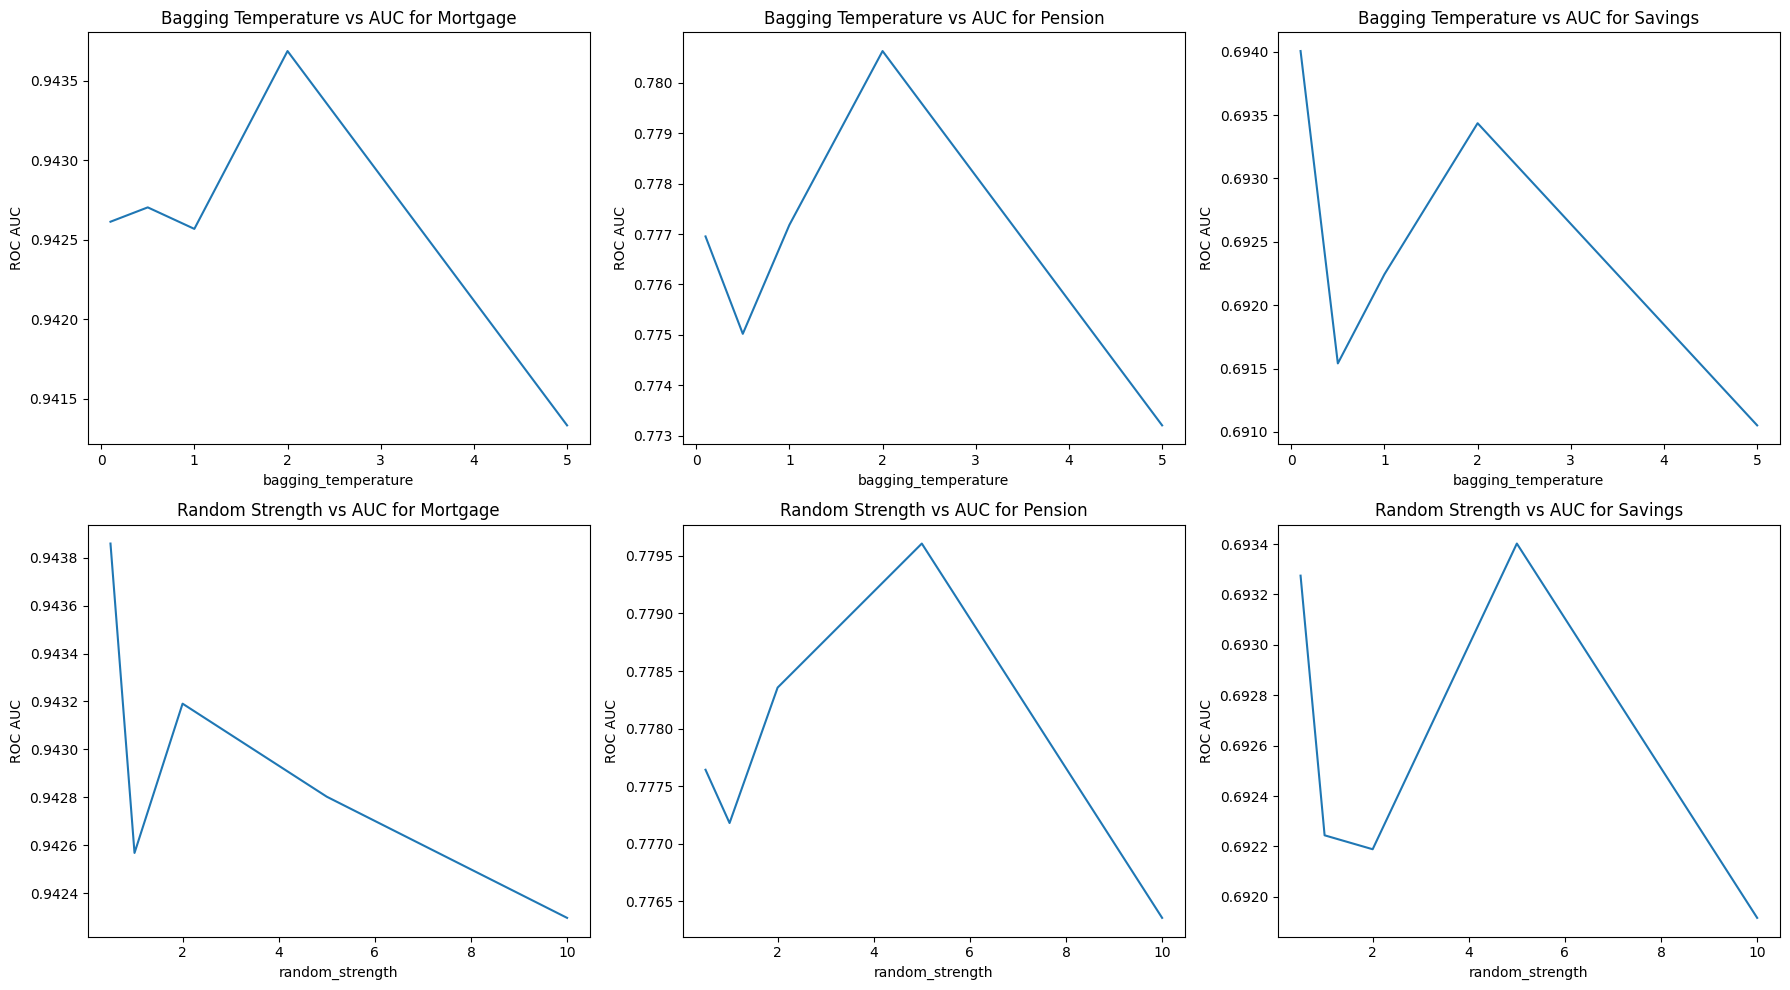

In [9]:
targets = ['Mortgage', 'Pension', 'Savings']
bagging_temps = [0.1, 0.5, 1, 2, 5]
random_strengths = [0.5, 1, 2, 5, 10]

results = {target: {'bagging_temps': [], 'random_strengths': [], 'aucs': []} for target in targets}

def train_catboost(X_train, y_train, X_val, y_val, bagging_temperature=None, random_strength=None):
    model = cb.CatBoostClassifier(
        iterations=1000,
        depth=10,
        learning_rate=0.035,
        loss_function='Logloss',
        task_type='GPU',
        verbose=0,
        bagging_temperature=bagging_temperature,
        random_strength=random_strength
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

for i, target in enumerate(tqdm(targets, desc="Processing targets")):
    train_df = train_data[i]
    val_df = val_data[i]

    X_train, y_train = train_df.drop(columns=[target]), train_df[target]
    X_val, y_val = val_df.drop(columns=[target]), val_df[target]

    for bagging_temp in tqdm(bagging_temps, desc=f"Bagging temps ({target})", leave=False):
        auc = train_catboost(X_train, y_train, X_val, y_val, bagging_temperature=bagging_temp)
        results[target]['bagging_temps'].append(bagging_temp)
        results[target]['aucs'].append(auc)

    for random_strength in tqdm(random_strengths, desc=f"Random strengths ({target})", leave=False):
        auc = train_catboost(X_train, y_train, X_val, y_val, random_strength=random_strength)
        results[target]['random_strengths'].append(random_strength)
        results[target]['aucs'].append(auc)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, target in enumerate(targets):
    axes[0, i].plot(results[target]['bagging_temps'], results[target]['aucs'][:len(bagging_temps)])
    axes[0, i].set_xlabel('bagging_temperature')
    axes[0, i].set_ylabel('ROC AUC')
    axes[0, i].set_title(f'Bagging Temperature vs AUC for {target}')

    axes[1, i].plot(results[target]['random_strengths'], results[target]['aucs'][len(bagging_temps):])
    axes[1, i].set_xlabel('random_strength')
    axes[1, i].set_ylabel('ROC AUC')
    axes[1, i].set_title(f'Random Strength vs AUC for {target}')

plt.tight_layout()
plt.show()